<a href="https://colab.research.google.com/github/lucianosilvacraam/astro/blob/master/Astroinform%C3%A1tica_II_Aula_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ASTROINFORMÁTICA II - Aula 09: Módulo simupy

http://github.com/simupy


In [1]:
!pip install simupy

     |████████████████████████████████| 184kB 5.0MB/s 
  Created wheel for simupy: filename=simupy-1.0.0-cp36-none-any.whl size=25596 sha256=93d873bd8e8b8e2cd2317166458db259d95901d147fa5da6d9892c7623207551
  Stored in directory: /root/.cache/pip/wheels/0e/4f/4e/661df4ffbc82bdb09a5fbce44a8d65f4c242122216183e9eeb
Successfully built simupy


In [0]:
from sympy.physics.mechanics import dynamicsymbols
from sympy.tensor.array import Array
from simupy.systems.symbolic import DynamicalSystem

x = x1, x2, x3 = Array(dynamicsymbols('x1:4'))
u = dynamicsymbols('u')
sys = DynamicalSystem(Array([-x1+x2-x3, -x1*x2-x2+u, -x1+u]), x, u)

Sistemas Dinâmicos LTI: https://en.wikipedia.org/wiki/Linear_time-invariant_system

In [0]:
from simupy.systems import LTISystem
ctrl = LTISystem([[1.73992128, 0.99212953,  -2.98819041]])

In [0]:
from simupy.block_diagram import BlockDiagram
BD = BlockDiagram(sys, ctrl)
BD.connect(sys, ctrl) # connect the current state to the feedback controller
BD.connect(ctrl, sys) # connect the controlled input to the system

In [0]:
sys.initial_condition = [5, -3, 1]
res = BD.simulate(40)

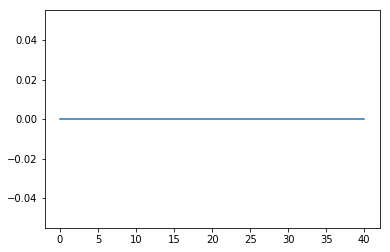

In [24]:
import matplotlib.pyplot as plt
plt.plot(res.t[:], res.x[:, 0])


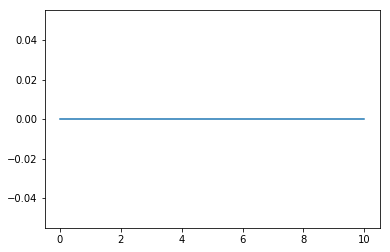

In [14]:
plt.plot(res.t[:], res.x[:, 1])

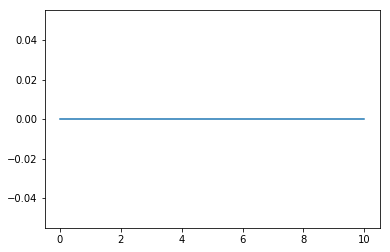

In [16]:
plt.plot(res.t[:], res.x[:, 2])

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


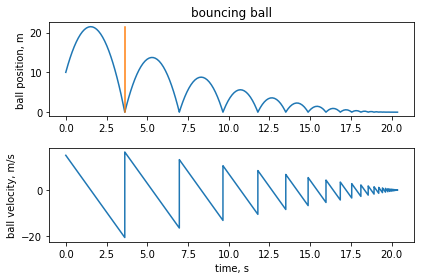

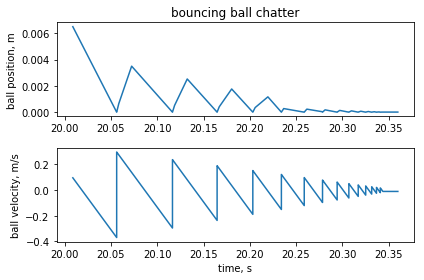

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols
from simupy.discontinuities import SwitchedSystem
from simupy import block_diagram
from simupy.array import Array, r_

BlockDiagram = block_diagram.BlockDiagram
int_opts = block_diagram.DEFAULT_INTEGRATOR_OPTIONS.copy()
find_opts = block_diagram.DEFAULT_EVENT_FIND_OPTIONS.copy()

"""
This example shows how to use a SwitchedSystem to model a bouncing ball. The
event detection accurately finds the point of impact, and the simulation
is generally accurate when the ball has sufficient energy. However, due to
numerical error, the simulation does show the ball chattering after all
the energy should have been dissipated.
"""

int_opts['rtol'] = 1E-12
int_opts['atol'] = 1E-15
int_opts['nsteps'] = 1000
int_opts['max_step'] = 2**-3

find_opts['xtol'] = 1E-12
find_opts['maxiter'] = int(1E3)


x = x1, x2 = Array(dynamicsymbols('x_1:3'))
mu, g = sp.symbols('mu g')
constants = {mu: 0.8, g: 9.81}
ic = np.r_[10, 15]
sys = SwitchedSystem(
    x1, Array([0]),
    state_equations=r_[x2, -g],
    state_update_equation=r_[sp.Abs(x1), -mu*x2],
    state=x,
    constants_values=constants,
    initial_condition=ic
)
bd = BlockDiagram(sys)
res = bd.simulate(
    20.36, integrator_options=int_opts, event_find_options=find_opts
)

expr_subs = constants.copy()
expr_subs[x1] = ic[0]
expr_subs[x2] = ic[1]
v1 = sp.sqrt(x2**2 + 2*g*x1).evalf(subs=expr_subs)
tstar = ((x2 + v1*(1 + mu)/(1-mu))/g).evalf(subs=expr_subs)

tvar = dynamicsymbols._t
impact_eq = (x2*tvar - g*tvar**2/2 + x1).subs(expr_subs)
t_impact = sp.solve(impact_eq, tvar)[-1]

# tstar is where the ball should come to a rest, however due to numerical
# error, it continues to chatter.
t_sel = (res.t < tstar*1.01)

plt.figure()
plt.subplot(2, 1, 1)
plt.title('bouncing ball')
plt.subplot(2, 1, 1)
plt.plot(res.t[t_sel], res.x[t_sel, 0])
plt.plot(2*[t_impact], [0, np.max(res.x[t_sel, 0])])
plt.ylabel('ball position, m')
plt.subplot(2, 1, 2)
plt.plot(res.t[t_sel], res.x[t_sel, 1])
plt.ylabel('ball velocity, m/s')
plt.xlabel('time, s')
plt.tight_layout()
plt.show()


plt.figure()
plt.subplot(2, 1, 1)
plt.title('bouncing ball chatter')
t_sel = (res.t > 20) & (res.t < tstar*1.03)
plt.subplot(2, 1, 1)
plt.plot(res.t[t_sel], res.x[t_sel, 0])
plt.ylabel('ball position, m')
plt.subplot(2, 1, 2)
plt.plot(res.t[t_sel], res.x[t_sel, 1])
plt.ylabel('ball velocity, m/s')
plt.xlabel('time, s')
plt.tight_layout()
plt.show()